# Analyzing patient data using polars

## Preliminaries

Load the required modules.

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

## Motivation

Since `polars` is often mentioned as a better alternative to `pandas` it is interesting to see how they stack up when coming from a `pandas` background.

Things currently (2024-09) missing:
* multi-level indices
* convenient plotting
* date-time data is not as convenient to query
* only linear interpolation, no automatic fill forward or backward

## Data set description

The data consists of two spreadsheets.

The first is data on patients gathered during an experimental trial.  The patients' temperature is measured at one-hour intervals, and each hour, the patients receive a dose of a drug to reduce fever.  The first column is a patient ID, the second is the dose, the third the datetime information, and the fourth the body temperature.

The second spreadsheet is metadata on the patients.  The first column is the patient ID, which should be consistent with that in the first spreadsheet, the second column denotes the gender of the patient, the third an experimental condition.

## Experiment data

Read the data set as a pandas `DataFrame` from an Excel spreadsheet.  The data is in the file `patient_experiment.xlsx`.

In [3]:
experiment_data = pl.read_excel('data/patient_experiment.xlsx')

Let's explore the data set a bit.

In [4]:
experiment_data.describe()

statistic,patient,dose,date,temperature
str,f64,f64,str,f64
"""count""",62.0,61.0,"""62""",61.0
"""null_count""",0.0,1.0,"""0""",1.0
"""mean""",4.983871,2.278689,"""2012-10-02 12:57:05.806000""",37.881967
"""std""",2.620799,2.989599,null,1.081127
"""min""",1.0,0.0,"""2012-10-02 10:00:00""",35.9
"""25%""",3.0,0.0,"""2012-10-02 11:00:00""",37.1
"""50%""",5.0,1.0,"""2012-10-02 13:00:00""",37.7
"""75%""",7.0,4.0,"""2012-10-02 15:00:00""",38.3
"""max""",9.0,12.0,"""2012-10-02 16:00:00""",40.7


`experiment_data` contains 4 columns, and 62 rows, and there seems to be missing data for `dose` and `temperature` since these columns have only 61 entries.  We also get descriptive statistics aoub the olumns.

Let's check the first few and last few rows.

In [5]:
experiment_data.head()

patient,dose,date,temperature
i64,i64,datetime[ms],f64
1,0,2012-10-02 10:00:00,38.3
1,2,2012-10-02 11:00:00,38.5
1,2,2012-10-02 12:00:00,38.1
1,2,2012-10-02 13:00:00,37.3
1,0,2012-10-02 14:00:00,37.5


In [6]:
experiment_data.tail()

patient,dose,date,temperature
i64,i64,datetime[ms],f64
9,12,2012-10-02 12:00:00,40.2
9,4,2012-10-02 13:00:00,39.1
9,4,2012-10-02 14:00:00,37.9
9,0,2012-10-02 15:00:00,37.1
9,0,2012-10-02 16:00:00,37.3


It seems that we have 9 patients, but lets verify that.

In [7]:
experiment_data['patient'].unique()

patient
i64
1
2
3
4
5
6
7
8
9


Let's check whether the number of measurements is equal for all 9 patients.

In [8]:
experiment_data.group_by(
    'patient',
    maintain_order=True
).agg(pl.col('patient').count().alias('count'))

patient,count
i64,u32
1,7
2,7
3,7
4,7
5,7
6,6
7,7
8,7
9,7


For all patients but one there are 7 measurements, for one there are only six.

In [9]:
experiment_data.filter(
    pl.col('patient') == 1,
).select(
    pl.col('date'),
)

date
datetime[ms]
2012-10-02 10:00:00
2012-10-02 11:00:00
2012-10-02 12:00:00
2012-10-02 13:00:00
2012-10-02 14:00:00
2012-10-02 15:00:00
2012-10-02 16:00:00


In [10]:
experiment_data.filter(
    pl.col('patient') == 6,
).select(
    pl.col('date'),
)

date
datetime[ms]
2012-10-02 10:00:00
2012-10-02 11:00:00
2012-10-02 12:00:00
2012-10-02 13:00:00
2012-10-02 14:00:00
2012-10-02 15:00:00


It is quite clear we will have to deal with missing data.

## Analyzing experiment data as a time series

We can now rearrange the data for a time series analysis by using the date as an index, and show the patient data as individual columns.

In [11]:
time_series = experiment_data.pivot(index='date',
                                    on=['patient'])
time_series

date,dose_1,dose_2,dose_3,dose_4,dose_5,dose_6,dose_7,dose_8,dose_9,temperature_1,temperature_2,temperature_3,temperature_4,temperature_5,temperature_6,temperature_7,temperature_8,temperature_9
datetime[ms],i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2012-10-02 10:00:00,0,0,0,0,0,0,0,0,0,38.3,39.3,37.9,38.1,37.9,37.5,39.5,37.8,38.3
2012-10-02 11:00:00,2,5,2,5,3,2,10,0,10,38.5,39.4,39.5,37.2,39.5,38.1,40.7,37.9,39.5
2012-10-02 12:00:00,2,5,5,5,7,3,5,0,12,38.1,38.1,38.3,36.1,38.3,37.9,39.8,37.4,40.2
2012-10-02 13:00:00,2,5,2,0,5,2,8,0,4,37.3,37.3,null,35.9,38.5,37.7,40.2,37.6,39.1
2012-10-02 14:00:00,0,0,2,null,9,1,3,0,4,37.5,36.8,37.7,36.3,39.4,37.2,38.3,37.3,37.9
2012-10-02 15:00:00,0,0,2,0,3,0,3,0,0,37.1,36.8,37.1,36.6,37.9,36.8,37.6,37.1,37.1
2012-10-02 16:00:00,0,0,0,0,0,null,1,0,0,36.8,36.8,36.7,36.7,37.2,null,37.3,36.8,37.3


Note that the missing data for patient 6 has been represented as `null`.

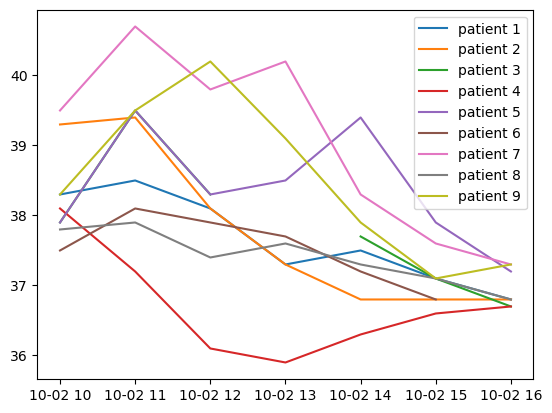

In [12]:
for patient in range(1, 10):
    plt.plot(time_series['date'], time_series[f'temperature_{patient}'],
             label=f'patient {patient}')
plt.legend();

Hm, something seems fishy with the data for patient 3, let's visualize it individually.

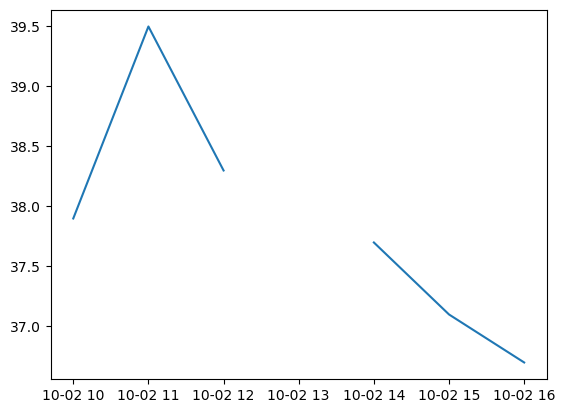

In [13]:
plt.plot(time_series['date'], time_series['temperature_3']);

The temperature for patient 3 was not measured at 13:00:00, but the dose was recorded. Let's check for other missing data more systematically.

In [14]:
time_series.select(
    pl.col('date'),
    pl.any_horizontal(pl.all().is_null()).alias('has_null'))

date,has_null
datetime[ms],bool
2012-10-02 10:00:00,false
2012-10-02 11:00:00,false
2012-10-02 12:00:00,false
2012-10-02 13:00:00,true
2012-10-02 14:00:00,true
2012-10-02 15:00:00,false
2012-10-02 16:00:00,true


We should take a look at the measurements for 13:00:00 and 14:00:00.

In [18]:
idx_time = datetime.strptime(
    '2012-10-02 13:00:00',
    '%Y-%m-%d %H:%M:%S'
)
time_series.filter(
    pl.col('date') == idx_time
)

date,dose_1,dose_2,dose_3,dose_4,dose_5,dose_6,dose_7,dose_8,dose_9,temperature_1,temperature_2,temperature_3,temperature_4,temperature_5,temperature_6,temperature_7,temperature_8,temperature_9
datetime[ms],i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2012-10-02 13:00:00,2,5,2,0,5,2,8,0,4,37.3,37.3,null,35.9,38.5,37.7,40.2,37.6,39.1


This was the temperature we were aware of, but at 14:00:00, it seems the dose was not recorded for patient 4.

In [19]:
idx_time = datetime.strptime('2012-10-02 14:00:00', '%Y-%m-%d %H:%M:%S')
time_series.filter(
    pl.col('date') == idx_time
)

date,dose_1,dose_2,dose_3,dose_4,dose_5,dose_6,dose_7,dose_8,dose_9,temperature_1,temperature_2,temperature_3,temperature_4,temperature_5,temperature_6,temperature_7,temperature_8,temperature_9
datetime[ms],i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2012-10-02 14:00:00,0,0,2,null,9,1,3,0,4,37.5,36.8,37.7,36.3,39.4,37.2,38.3,37.3,37.9


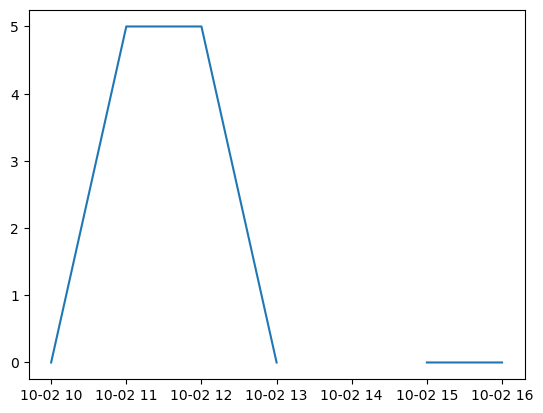

In [16]:
plt.plot(time_series['date'], time_series['dose_4']);

From the plots, it seems reasonable to do a linear interpolation for both missing data points.

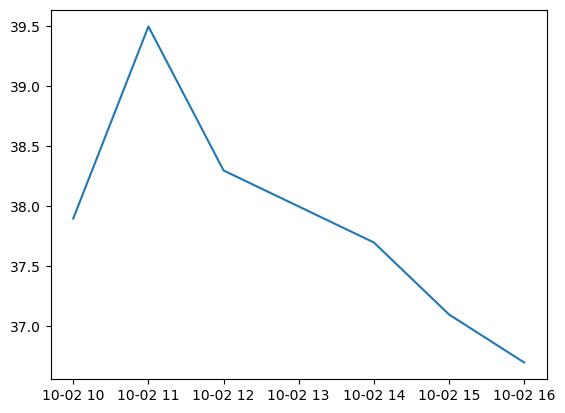

In [20]:
interpolated_3 = time_series.with_columns(
    pl.col('temperature_3').interpolate()
)
plt.plot(interpolated_3['date'], interpolated_3['temperature_3']);

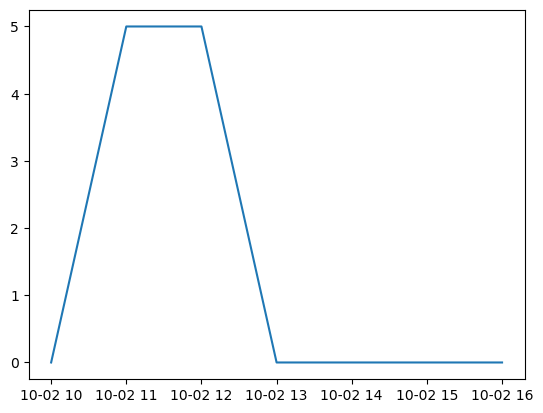

In [21]:
interpolated_4 = time_series.with_columns(pl.col('dose_4').interpolate())
plt.plot(interpolated_4['date'], interpolated_4['dose_4']);

Let's do the interpolation on the time series in place.

In [22]:
time_series = time_series.interpolate()

We should have no more missing data, let's verify.

In [23]:
time_series.select(
    pl.col('date'),
    pl.any_horizontal(pl.all().is_null()).alias('has_null')
)

date,has_null
datetime[ms],bool
2012-10-02 10:00:00,false
2012-10-02 11:00:00,false
2012-10-02 12:00:00,false
2012-10-02 13:00:00,false
2012-10-02 14:00:00,false
2012-10-02 15:00:00,false
2012-10-02 16:00:00,true


Hm, not quite, data is still missing for the last time point.  Since interpolation is not possible here, we can use the `forward` strategy for `fill_null` instread.

In [24]:
time_series = time_series.fill_null(strategy='forward')

Let's verify what happend for patient 6 with the missing data at the end of the experiment.

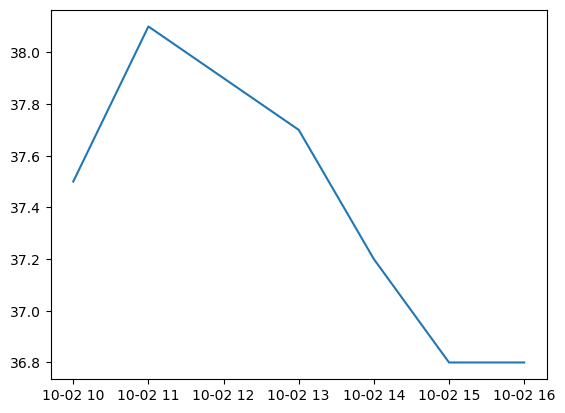

In [25]:
plt.plot(time_series['date'], time_series['temperature_6']);

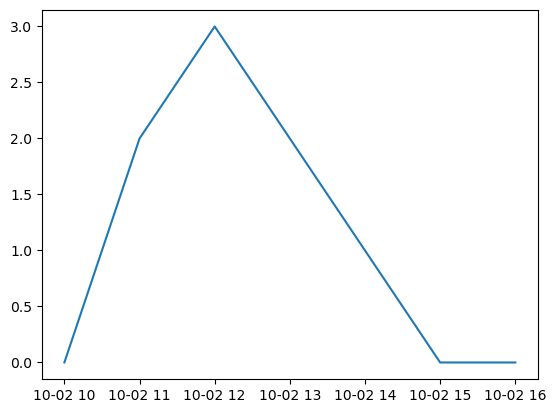

In [26]:
plt.plot(time_series['date'], time_series['dose_6']);

The value is the same for 16h as for 15h, which is reasonable.

## Derived data

Let's add a new column to the time series that represents the average temperature over all patients.

In [27]:
time_series = time_series.select(
    pl.all(),
    pl.mean_horizontal(pl.col(r'^temperature_\d+$')).alias('avg_temp')
)

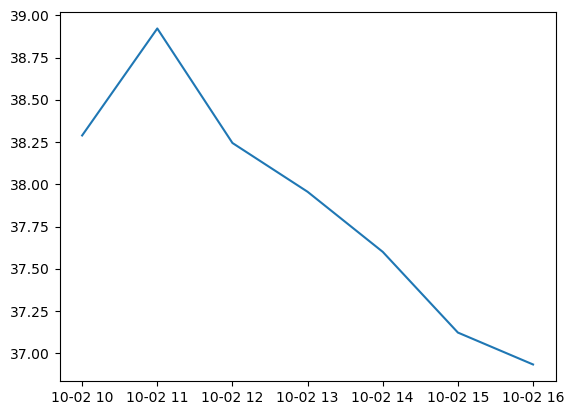

In [28]:
plt.plot(time_series['date'], time_series['avg_temp']);

Let's also add a column for each patient that shows the cummulative dose for that patient.

In [29]:
for patient in range(1, 10):
    time_series = time_series.select(
        pl.all(),
        pl.col(f'dose_{patient}').cum_sum().alias(f'cum_dose_{patient}')
    )

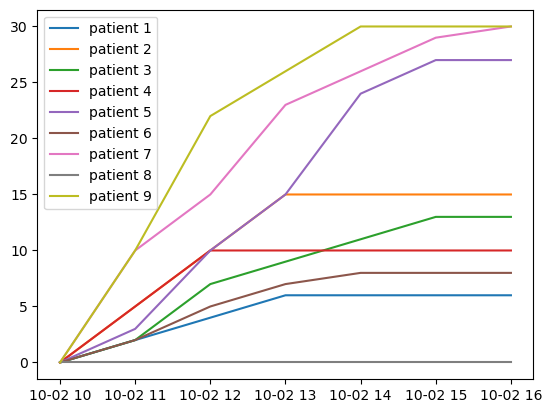

In [30]:
for patient in range(1, 10):
    plt.plot(time_series['date'], time_series[f'cum_dose_{patient}'],
             label=f'patient {patient}')
plt.legend();

Let's check the maximum temperature and the total dose per patient using a pivot table. We index by patient, while the values should be the dose and the temperature, aggregated as sum and maximum respectively.

In [31]:
hypothesis = experiment_data.select('patient', 'dose', 'temperature').group_by('patient').agg(pl.col('dose').sum(), pl.col('temperature').max())
hypothesis

patient,dose,temperature
i64,i64,f64
5,27,39.5
8,0,37.9
9,30,40.2
2,15,39.4
1,6,38.5
4,10,38.1
7,30,40.7
3,13,39.5
6,8,38.1


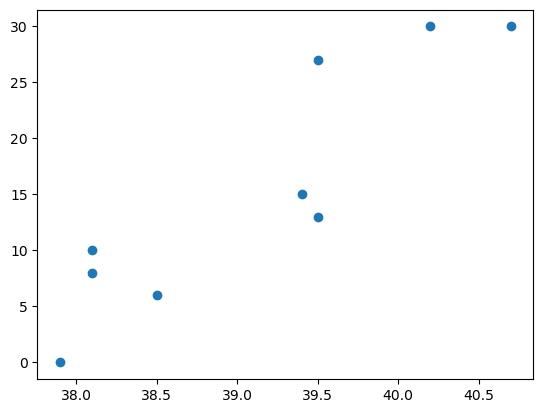

In [32]:
plt.plot(hypothesis['temperature'], hypothesis['dose'], 'o');

It seems possible that there is a linear relationship between the maximum temperature, and the total dose administered during the experiment. Let's use Seaborn to copmute and display a linear regression on the data.

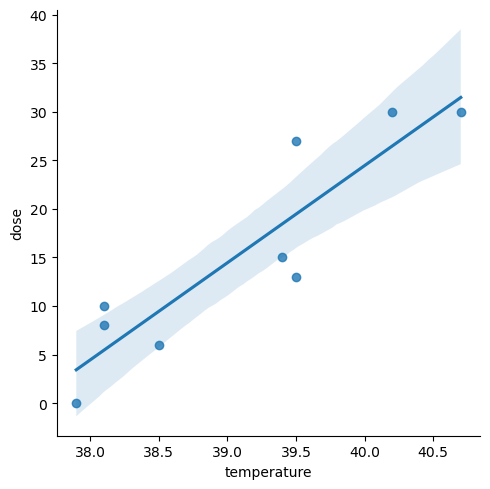

In [33]:
sns.lmplot(x='temperature', y='dose', data=hypothesis);

## Metadata

There is a second file with metadata on the patients, let's read that as well. The data is in de file `patient_metadata.xlsx`.

In [34]:
metadata = pl.read_excel('data/patient_metadata.xlsx',
                         schema_overrides={
                             'gender': pl.Categorical,
                             'condition': pl.Categorical,
                         })
metadata

patient,gender,condition
i64,cat,cat
1,"""M""","""A"""
2,"""F""","""A"""
3,"""M""","""A"""
5,"""M""","""A"""
6,"""F""","""B"""
7,"""M""","""B"""
8,"""F""","""B"""
9,"""M""","""B"""
10,"""F""","""B"""



How many distinct genders and conditions do we have?

In [35]:
for column in ['gender' ,'condition']:
    values = metadata[column].unique()
    print(column, ':', values, '->', len(values))

gender : shape: (2,)
Series: 'gender' [cat]
[
	"M"
	"F"
] -> 2
condition : shape: (2,)
Series: 'condition' [cat]
[
	"A"
	"B"
] -> 2


Gender and condition are categorical data,  `describe` doesn't provide a lot of information.

Which patients are male, and have condition A?

In [36]:
metadata.filter((pl.col('gender') == 'M') & (pl.col('condition') == 'A'))

patient,gender,condition
i64,cat,cat
1,"""M""","""A"""
3,"""M""","""A"""
5,"""M""","""A"""


## Merging dataframes

The patient IDs in the exerperimental and metadata should correspond, so let merge the dataframes. However, let's first check whether the patient IDs are the same in both dataframes.

In [37]:
patients_experiment = set(experiment_data['patient'])
patients_metadata = set(metadata['patient'])
print(patients_experiment - patients_metadata)
print(patients_metadata - patients_experiment)

{4}
{10, 11}


So metadata is missing for patient 4, and there is metadata for patients that were not involved in the experiment (10 and 11).  Since we are not interested in the latter, and should keep the data on patient 4 regardless of metadata, we do a left-join of the data of the experiment, and the metadata.

In [38]:
data = experiment_data.join(metadata, on='patient')

How many patients involved in our experiment are male, and how many female?

In [39]:
data['patient', 'gender'] \
    .unique() \
    .group_by('gender') \
    .agg(pl.col('gender').count().alias('gender_count')) \
    .drop_nulls()

gender,gender_count
cat,u32
"""M""",5
"""F""",3


Which patients had a temperature higher than $39^{\circ}$, and when?  Let's also display the gender.

In [40]:
data['patient', 'date', 'temperature', 'gender'] \
    .filter(pl.col('temperature') > 39.0)

patient,date,temperature,gender
i64,datetime[ms],f64,cat
2,2012-10-02 10:00:00,39.3,"""F"""
2,2012-10-02 11:00:00,39.4,"""F"""
3,2012-10-02 11:00:00,39.5,"""M"""
5,2012-10-02 11:00:00,39.5,"""M"""
5,2012-10-02 14:00:00,39.4,"""M"""
…,…,…,…
7,2012-10-02 12:00:00,39.8,"""M"""
7,2012-10-02 13:00:00,40.2,"""M"""
9,2012-10-02 11:00:00,39.5,"""M"""


Suspiciously many males, let's see how many males versus females had a temperature (at any point).

In [41]:
data.filter(pl.col('temperature') > 39.0) \
    .select('patient', 'gender').unique() \
    .group_by('gender') \
    .agg(pl.col('patient').count())

gender,patient
cat,u32
"""M""",4
"""F""",1


## Gender differences?

There might be a gender influence here. Let's split our data set into male and female patients.

In [42]:
male_series = data.drop_nulls() \
    .filter(pl.col('gender') == 'M') \
    .select('date', 'patient', 'dose', 'temperature') \
    .pivot(on='patient', index='date') \
    .fill_null(strategy='forward')

In [43]:
female_series = data.drop_nulls() \
    .filter(pl.col('gender') == 'F') \
    .select('date', 'patient', 'dose', 'temperature') \
    .pivot(on='patient', index='date') \
    .fill_null(strategy='forward')

In [44]:
female_series

date,dose_2,dose_6,dose_8,temperature_2,temperature_6,temperature_8
datetime[ms],i64,i64,i64,f64,f64,f64
2012-10-02 10:00:00,0,0,0,39.3,37.5,37.8
2012-10-02 11:00:00,5,2,0,39.4,38.1,37.9
2012-10-02 12:00:00,5,3,0,38.1,37.9,37.4
2012-10-02 13:00:00,5,2,0,37.3,37.7,37.6
2012-10-02 14:00:00,0,1,0,36.8,37.2,37.3
2012-10-02 15:00:00,0,0,0,36.8,36.8,37.1
2012-10-02 16:00:00,0,0,0,36.8,36.8,36.8


Note that now the data for patient 4 is missing, since the gender is unknown.

Let's compute the average temperature for male and female patients, compare.

In [45]:
male_avg_temps = male_series.select(
    pl.col('date'),
    pl.mean_horizontal(pl.col(r'^temperature_.*$')) \
        .alias('male_mean_temperature')
)

In [46]:
femail_avg_temps = female_series.select(
    pl.col('date'),
    pl.mean_horizontal(pl.col(r'^temperature_.*$')) \
        .alias('female_mean_temperature'))

In [47]:
temps = male_avg_temps.join(femail_avg_temps, on='date')
temps

date,male_mean_temperature,female_mean_temperature
datetime[ms],f64,f64
2012-10-02 10:00:00,38.38,38.2
2012-10-02 11:00:00,39.54,38.466667
2012-10-02 12:00:00,38.94,37.8
2012-10-02 13:00:00,38.68,37.533333
2012-10-02 14:00:00,38.16,37.1
2012-10-02 15:00:00,37.36,36.9
2012-10-02 16:00:00,37.06,36.8


These are two `Series`, we can concatenate these into a single `DataFrame`.

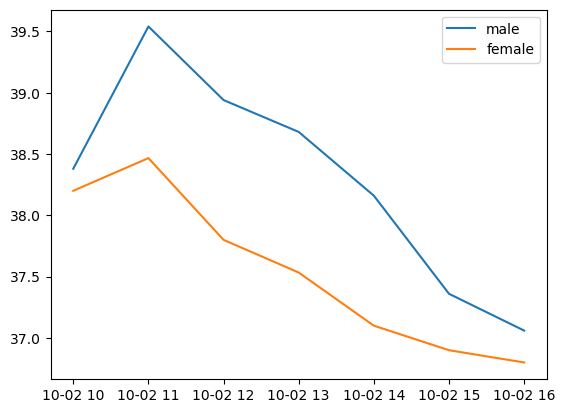

In [48]:
plt.plot(temps['date'], temps['male_mean_temperature'],
         label='male')
plt.plot(temps['date'], temps['female_mean_temperature'],
         label='female')
plt.legend();

Looks like we are on to something, pity this is not real data.

In [49]:
data.group_by('patient') \
    .agg(
        pl.col('temperature').max(),
        pl.col('dose').sum(),
        pl.col('gender').first(),
    ) \
    .pivot(on='gender', index='patient')

patient,temperature_M,temperature_F,dose_M,dose_F
i64,f64,f64,i64,i64
1,38.5,null,6,null
3,39.5,null,13,null
8,null,37.9,null,0
2,null,39.4,null,15
9,40.2,null,30,null
6,null,38.1,null,8
7,40.7,null,30,null
5,39.5,null,27,null


## Conditions

However, we didn't take the patients' condition into account yet. Let's check how many patients have a specific condition.

In [50]:
data['patient', 'condition'] \
    .unique() \
    .group_by('condition') \
    .agg(pl.all().count().alias('nr_patients'))

condition,nr_patients
cat,u32
"""B""",4
"""A""",4


What is the distribution of the condition with respect to the patients's gender?

In [51]:
distribution = data['patient', 'condition', 'gender'] \
    .unique() \
    .group_by('condition', 'gender') \
    .agg(pl.all().count().alias('nr_patients'))
distribution

condition,gender,nr_patients
cat,cat,u32
"""A""","""F""",1
"""B""","""F""",2
"""A""","""M""",3
"""B""","""M""",2


In [52]:
labeled_distribution = distribution.select(
    ('(' + pl.col("condition") + ', ' + pl.col("gender") + ')').alias('label'),
    pl.col('nr_patients')
)
labeled_distribution

label,nr_patients
str,u32
"""(A, F)""",1
"""(B, F)""",2
"""(A, M)""",3
"""(B, M)""",2


This data can be conveniently visualized using a bar plot.

<BarContainer object of 4 artists>

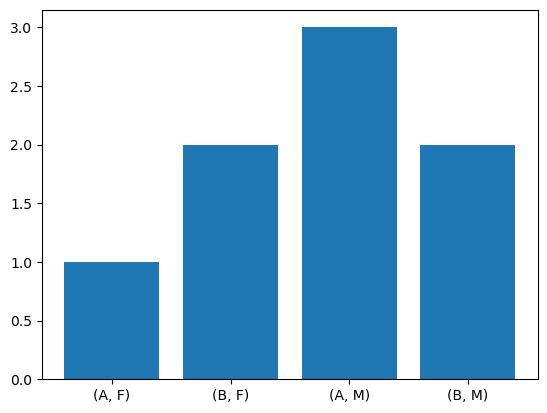

In [53]:
plt.bar(labeled_distribution['label'], labeled_distribution['nr_patients'])

## From numbers to categories

Let's create an extra column in the `DataFrame` that is categorical, and represents the status of the patients in terms of fever.

In [54]:
status_data = data.select(
    pl.all(),
    pl.col('temperature').cut((37.5, 39.0),
                              labels=('normal', 'fever', 'high fever'),
                              ).alias('status')
)
status_data

patient,dose,date,temperature,gender,condition,status
i64,i64,datetime[ms],f64,cat,cat,cat
1,0,2012-10-02 10:00:00,38.3,"""M""","""A""","""fever"""
1,2,2012-10-02 11:00:00,38.5,"""M""","""A""","""fever"""
1,2,2012-10-02 12:00:00,38.1,"""M""","""A""","""fever"""
1,2,2012-10-02 13:00:00,37.3,"""M""","""A""","""normal"""
1,0,2012-10-02 14:00:00,37.5,"""M""","""A""","""normal"""
…,…,…,…,…,…,…
9,12,2012-10-02 12:00:00,40.2,"""M""","""B""","""high fever"""
9,4,2012-10-02 13:00:00,39.1,"""M""","""B""","""high fever"""
9,4,2012-10-02 14:00:00,37.9,"""M""","""B""","""fever"""


In [55]:
status_data['date', 'patient', 'status'].group_by('status').agg(pl.col('patient').count().alias('nr_measurements'))

status,nr_measurements
cat,u32
null,1
"""fever""",21
"""normal""",21
"""high fever""",12


A similar query to the one we did before can now be done on the `status` attribute.

In [56]:
status_data.filter(pl.col('status') == 'high fever')

patient,dose,date,temperature,gender,condition,status
i64,i64,datetime[ms],f64,cat,cat,cat
2,0,2012-10-02 10:00:00,39.3,"""F""","""A""","""high fever"""
2,5,2012-10-02 11:00:00,39.4,"""F""","""A""","""high fever"""
3,2,2012-10-02 11:00:00,39.5,"""M""","""A""","""high fever"""
5,3,2012-10-02 11:00:00,39.5,"""M""","""A""","""high fever"""
5,9,2012-10-02 14:00:00,39.4,"""M""","""A""","""high fever"""
…,…,…,…,…,…,…
7,5,2012-10-02 12:00:00,39.8,"""M""","""B""","""high fever"""
7,8,2012-10-02 13:00:00,40.2,"""M""","""B""","""high fever"""
9,10,2012-10-02 11:00:00,39.5,"""M""","""B""","""high fever"""


The patients with high fever are given by:

In [57]:
status_data['patient', 'status'] \
    .filter(pl.col('status') == 'high fever') \
    .unique() \
    .select(pl.col('patient'))

patient
i64
7
9
3
5
2


This result is the same as for the query we performed earlier.